In [89]:
import pandas as pd
import plotnine as pn

# Get credentials
with open('/home/andreas/Dropbox/Projects/scoring-probability/credentials', 'r') as credentials_file:
    URI = credentials_file.read()
    
# Get query
with open('player-scored-query.sql', 'r') as query_file:
    query = query_file.read()
    
# Pandas
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

In [90]:
# Get the data
result = pd.read_sql(query, URI)

In [91]:
result.head()

,fixture_uid,team_uid,is_home,player_uid,kick_off,gameweek,season,position,played,scored,appearance_number,matches_scored,match_number,matches_scored_until_now,appearances_until_now,matches_until_now,chance_score_given_played,chance_score
0,c234ba3c78a51d023833c83b88a7fa5d,9d292673b9c1ebe339be9d36032d5e2e,1,015ab60ee2fcf75b0326823cf47fc32b,2019-08-10 12:30:00,1,1920,gk,0,0,0,0,1,0,15,15,0,0
1,d7527be5828734075d0caa9194c69437,9d292673b9c1ebe339be9d36032d5e2e,0,015ab60ee2fcf75b0326823cf47fc32b,2019-08-17 15:00:00,2,1920,gk,0,0,0,0,2,0,16,17,0,0
2,282a535c1a57b5aa490b45927d41c57a,9d292673b9c1ebe339be9d36032d5e2e,0,015ab60ee2fcf75b0326823cf47fc32b,2019-08-24 15:00:00,3,1920,gk,0,0,0,0,3,0,16,18,0,0
3,51c192c4d46d8e91d3068f0fd56d3e75,9d292673b9c1ebe339be9d36032d5e2e,1,015ab60ee2fcf75b0326823cf47fc32b,2019-08-31 15:00:00,4,1920,gk,0,0,0,0,4,0,15,18,0,0
4,754a58406ca76df91d773087f45f2ccd,9d292673b9c1ebe339be9d36032d5e2e,0,015ab60ee2fcf75b0326823cf47fc32b,2019-09-16 20:00:00,5,1920,gk,0,0,0,0,5,0,16,20,0,0


In [92]:
# Get some info on the player
player_query = """
select a.uid as player_uid, a.name, b.name as team_name, primary_color from data_players a join data_teams b on a.team_uid = b.uid
"""

player_info = pd.read_sql(player_query, URI)

player_info['primary_color'] = player_info.primary_color.replace('_', '', regex=True)

In [93]:
result_w_info = result.merge(player_info)

## Who is the most likely to have scored each game week?

In [20]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.animation as animation
from IPython.display import HTML

In [83]:
# Note that within a gameweek we could duplicate
s_by = ['gameweek', 'chance_score']
g_by = s_by[0]
keep = ['name', 'team_name', 'chance_score', 'gameweek', 'primary_color']
top_players = result_w_info.sort_values(s_by, ascending=[True, False]).groupby(g_by).head(6)[keep].sort_values(s_by)

In [84]:
def draw_barchart(gameweek):
    c = top_players.gameweek == gameweek
    
    ax.clear()
    ax.barh(top_players.loc[c, 'name'], top_players.loc[c, 'chance_score'], color=top_players.loc[c, 'primary_color'])
    
    for i, (value, name) in enumerate(zip(top_players.loc[c, 'chance_score'], top_players.loc[c, 'name'])):
        team_name = player_info.loc[player_info.name == name, 'team_name'].iloc[0]
        
        ax.text(value, i, name + ' ', size=14, weight=600, ha='right', va='bottom')  # Tokyo: name
        ax.text(value, i-.25, team_name + ' ', size=14, color='#444444', ha='right', va='baseline')  # Asia: group name
        ax.text(value, i, f'  {value:,.0f}', size=14, ha='left',  va='center')   # 38194.2: value
    
    # ... polished styles
    ax.text(1, 0.4, gameweek, transform=ax.transAxes, color='#777777', size=46, ha='right', weight=800)
    ax.text(0, 1.06, 'Probability to score', transform=ax.transAxes, size=12, color='#777777')
    ax.xaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
    ax.xaxis.set_ticks_position('top')
    ax.tick_params(axis='x', colors='#777777', labelsize=12)
    ax.set_yticks([])
    ax.margins(0, 0.01)
    ax.grid(which='major', axis='x', linestyle='-')
    ax.set_axisbelow(True)
    ax.text(0, 1.12, 'Most probable goal scores each gameweek',
            transform=ax.transAxes, size=24, weight=600, ha='left')
    plt.box(False)

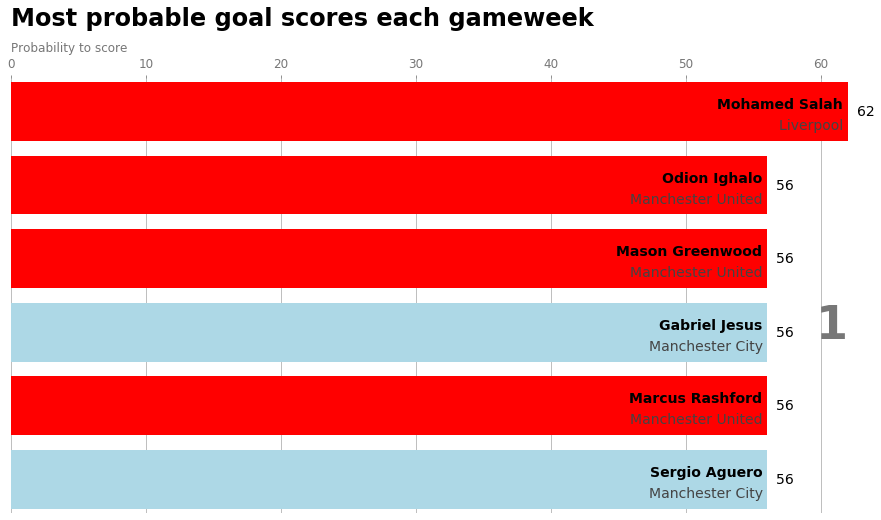

In [85]:
fig, ax = plt.subplots(figsize=(15, 8))
animator = animation.FuncAnimation(fig, draw_barchart, interval=2000, frames=range(top_players.gameweek.min(), top_players.gameweek.max() + 1))
animator.save('scorers-race.gif', writer='imagemagick');
#HTML(animator.to_html5_video())
#HTML(animator.to_jshtml()) 
# or use animator.to_html5_video() or animator.save()

## How does the probability to score change over the season?

In [100]:
result_w_info = result_w_info.sort_values('kick_off').reset_index(drop=True)

In [101]:
result_w_info['score_change'] = result_w_info.groupby('player_uid').chance_score.diff()

In [123]:
bins = list(range(0, 121, 20))
result_w_info['score_bin'] = pd.cut(result_w_info.chance_score, bins, labels=bins[:-1], include_lowest=True)


In [125]:
change_agg = result_w_info.groupby(['gameweek', 'score_bin']).score_change.agg(['mean', 'sem']).dropna().reset_index()

/home/andreas/anaconda3/lib/python3.6/site-packages/plotnine/scales/scale.py:93: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cbook.iterable(self.breaks) and cbook.iterable(self.labels):
/home/andreas/anaconda3/lib/python3.6/site-packages/plotnine/utils.py:553: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  return cbook.iterable(var) and not is_string(var)


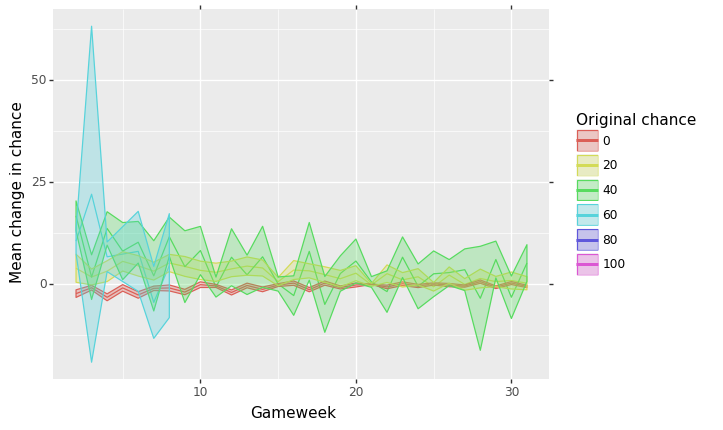

In [129]:
graph = pn.ggplot(change_agg, pn.aes(x='gameweek', y='mean', 
                                     ymax='mean + 1.96*sem', ymin='mean - 1.96*sem', 
                                     color='score_bin', fill='score_bin')) \
+ pn.geom_line() + pn.geom_ribbon(alpha=0.3) \
+ pn.ylab('Mean change in chance') + pn.xlab('Gameweek') \
+ pn.scale_color_discrete(name='Original chance') + pn.scale_fill_discrete(name='Original chance') 

graph.draw();

In [132]:
# Same thing but difference with first gameweek
first_score = result_w_info.loc[result_w_info.gameweek == 1, ['player_uid', 'chance_score']]
w_first_score = result_w_info.dropna(subset=['score_change']).merge(first_score, on='player_uid', suffixes=['', '_first'])

In [133]:
w_first_score['score_change'] = w_first_score.chance_score - w_first_score.chance_score_first

In [134]:
change_agg = w_first_score.groupby(['gameweek', 'score_bin']).score_change.agg(['mean', 'sem']).dropna().reset_index()

/home/andreas/anaconda3/lib/python3.6/site-packages/plotnine/scales/scale.py:93: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cbook.iterable(self.breaks) and cbook.iterable(self.labels):
/home/andreas/anaconda3/lib/python3.6/site-packages/plotnine/utils.py:553: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  return cbook.iterable(var) and not is_string(var)


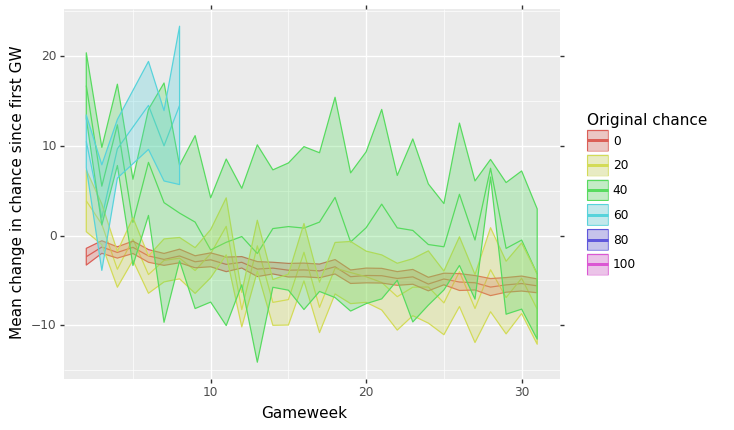

In [135]:
graph = pn.ggplot(change_agg, pn.aes(x='gameweek', y='mean', 
                                     ymax='mean + 1.96*sem', ymin='mean - 1.96*sem', 
                                     color='score_bin', fill='score_bin')) \
+ pn.geom_line() + pn.geom_ribbon(alpha=0.3) \
+ pn.ylab('Mean change in chance since first GW') + pn.xlab('Gameweek') \
+ pn.scale_color_discrete(name='Original chance') + pn.scale_fill_discrete(name='Original chance') 

graph.draw();

### How does the rank within players change over the season?

In [ ]:
# Note that within a gameweek we could duplicate
s_by = ['gameweek', 'chance_score']
g_by = s_by[0]
keep = ['name', 'team_name', 'chance_score', 'gameweek', 'primary_color']
top_players = result_w_info.sort_values(s_by, ascending=[True, False]).groupby(g_by).head(6)[keep].sort_values(s_by)

In [140]:
result_w_info['prob_rank'] = result_w_info.sort_values(s_by, ascending=[True, False]).groupby(g_by).chance_score.rank(method='dense', ascending=False)

In [141]:
result_w_info = result_w_info.sort_values('kick_off').reset_index(drop=True)
result_w_info['rank_change'] = result_w_info.groupby('player_uid').prob_rank.diff()
change_agg = result_w_info.groupby(['gameweek', 'score_bin']).rank_change.agg(['mean', 'sem']).dropna().reset_index()

/home/andreas/anaconda3/lib/python3.6/site-packages/plotnine/scales/scale.py:93: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cbook.iterable(self.breaks) and cbook.iterable(self.labels):
/home/andreas/anaconda3/lib/python3.6/site-packages/plotnine/utils.py:553: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  return cbook.iterable(var) and not is_string(var)


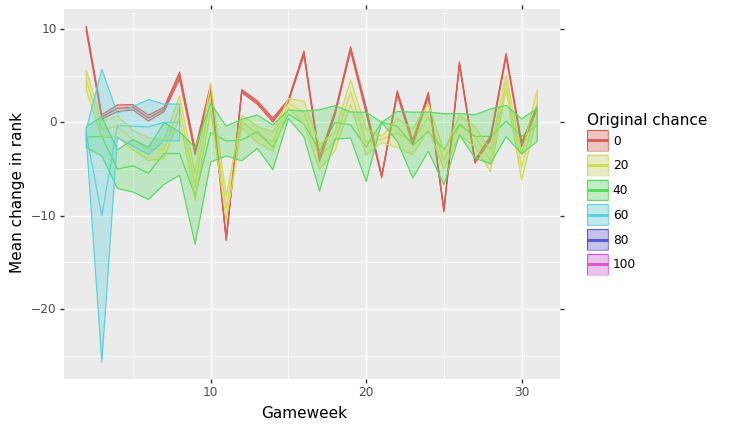

In [142]:
graph = pn.ggplot(change_agg, pn.aes(x='gameweek', y='mean', 
                                     ymax='mean + 1.96*sem', ymin='mean - 1.96*sem', 
                                     color='score_bin', fill='score_bin')) \
+ pn.geom_line() + pn.geom_ribbon(alpha=0.3) \
+ pn.ylab('Mean change in rank') + pn.xlab('Gameweek') \
+ pn.scale_color_discrete(name='Original chance') + pn.scale_fill_discrete(name='Original chance') 

graph.draw();

### Reduced query trial

In [183]:
# Get query
with open('reduced-query.sql', 'r') as query_file:
    reduced_query = query_file.read()

In [184]:
result = pd.read_sql(reduced_query.format(input_gameweek='30', input_current_season='1920', input_previous_season='1920'), URI)

In [185]:
result

,player_uid,probability
0,015ab60ee2fcf75b0326823cf47fc32b,0.000000
1,022b72fc5bb47da7fd60cdef6a5fe1dc,0.166667
2,0243e18f7c18ca4b92346d0cdb79ec9b,0.413793
3,02545593f1e2ab515b3bc0501560fa47,0.068966
4,036c80e1772a55dc14d13e815b0c5c29,0.241379
...,...,...
516,fb9bdc92af8fc85f0428675e1e01f8fa,0.034483
517,fcd90a513fe4f64a8971e9ae263909a9,0.000000
518,fcfea2948eee51f34a49d78fcbe36965,0.068966
519,fe4b7bf4949fdd42bbec754715dc1fac,0.166667


In [186]:
result.probability.describe()

count    521.000000
mean       0.093473
std        0.102731
min        0.000000
25%        0.000000
50%        0.068966
75%        0.137931
max        0.500000
Name: probability, dtype: float64

In [188]:
import datetime
current_time = datetime.datetime.now()

In [192]:
current_time.year

2020

In [198]:
str(current_time.year - 1)[-2:]

'19'

In [199]:
year = current_time.year

In [201]:
int(str(year[-2:]) + str(year + 1)[-2:])

TypeError: 'int' object is not subscriptable

In [206]:
int(str(year)[-2:] + str(year + 1)[-2:])

2021

In [208]:
curr_season = '2021'

In [209]:
str(int(str(curr_season)[:2]) - 1) + str(int(str(curr_season)[-2:]) - 1)

'1920'